In [1]:
import geopandas as gpd
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load data

data = pd.read_pickle('data/grid_roads.pkl')
data.drop(columns=['ADM_SECT_C', 'SGG_NM', 'SGG_OID','COL_ADM_SE'], inplace=True)

In [8]:
roads = gpd.read_file('data/seoul_road/Z_KAIS_TL_SPRD_MANAGE_11.shp', encoding='euc-kr', crs='epsg:5179')
roads = roads.to_crs('epsg:5174')
roads = roads[roads.ROA_CLS_SE.isin(['1','2','3'])]

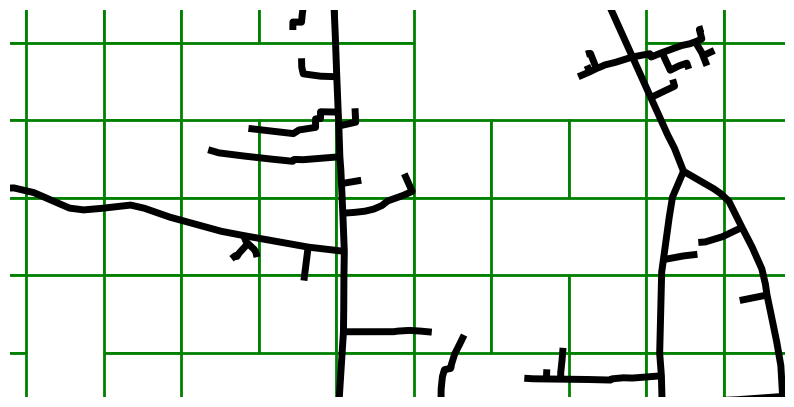

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)
data.plot(ax=ax, color='white', edgecolor='green', linewidth=2.0)
roads.plot(ax=ax, color='black', linewidth=5.0)

left,right = 198000, 199000
bottom,top = 452000, 452500

# Set the limits of x and y to zoom in
ax.set_xlim([left, right])  # replace 'left' and 'right' with the desired values
ax.set_ylim([bottom, top])  # replace 'bottom' and 'top' with the desired values

plt.axis('off')
plt.show()

In [4]:
# EDA

data.describe()

,flood,office_cat_0,office_cat_1,office_cat_2,office_cat_3,office_cat_4,office_cat_5,office_cat_6,office_cat_7,office_cat_8,office_cat_9,elevation,rainpump,trees,road_area,trashcan
count,18735.000000,18735.000000,18735.000000,18735.000000,18735.000000,18735.000000,18735.000000,18735.000000,18735.000000,18735.000000,18735.000000,11524.000000,18735.000000,18735.000000,18675.000000,18735.000000
mean,0.407046,1.156605,0.607900,0.642701,2.227435,3.405284,2.663891,0.474513,0.581479,0.163064,0.199733,30.285933,1529.809252,6.541446,2441.364212,0.077235
std,2.668411,2.374382,2.015839,2.498513,9.758222,7.638573,11.071279,1.394670,2.523376,0.768037,1.174045,26.996310,1348.590733,12.989011,7675.605381,0.980629
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.900000,560.184571,0.000000,481.745267,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.395000,1105.149399,0.000000,1879.468992,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,35.892500,2079.746826,10.000000,3085.230187,0.000000
max,66.000000,37.000000,130.000000,122.000000,280.000000,110.000000,626.000000,24.000000,98.000000,23.000000,43.000000,321.724991,8821.928984,578.000000,548005.880433,46.000000


<Axes: >

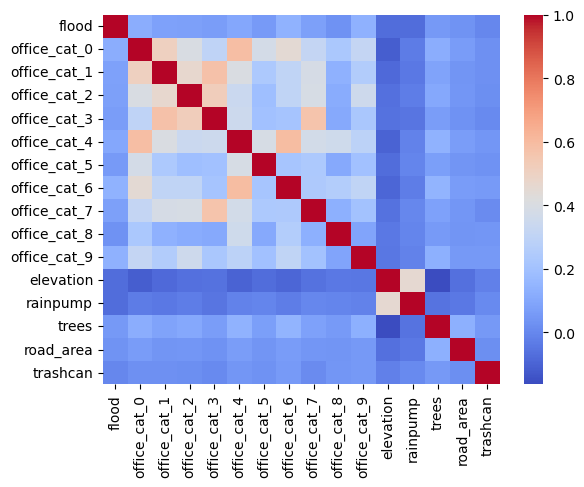

In [5]:
# Correlation matrix

corr = data.drop(columns=['geometry']).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')

In [6]:
# Linear modeling

# GLM with Poisson link

import statsmodels.api as sm

X = data.drop(columns=['geometry', 'flood'])

# Standardize
X = (X - X.mean()) / X.std()

X = sm.add_constant(X)

# replace elevation nan with mean
X['elevation'] = X['elevation'].fillna(X['elevation'].mean())

# replace road area nan with 0
X['road_area'] = X['road_area'].fillna(0)

y = data['flood']



model_ols = sm.OLS(y, X).fit()

model_glm = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# ols result to table

model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  flood   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     48.23
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          1.35e-141
Time:                        04:37:37   Log-Likelihood:                -44616.
No. Observations:               18735   AIC:                         8.926e+04
Df Residuals:                   18719   BIC:                         8.939e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4070      0.019     21.270      0.000       0.370       0.445
office_cat_0     0.1400      0.027      5.249      0.000       0.088       0.192
office_cat_1    -0.0043      0.026     -0.165      0.869      -0.056       0.047
office_cat_2    -0.0377      0.024     -1.544      0.123      -0.085       0.010
office_cat_3     0.0188      0.028      0.679      0.497      -0.036       0.073
office_cat_4    -0.0609      0.029     -2.114      0.035      -0.117      -0.004
office_cat_5     0.0041      0.021      0.192      0.848      -0.038       0.046
office_cat_6     0.2579      0.025     10.473      0.000       0.210       0.306
office_cat_7     0.0668      0.024      2.780      0.005       0.020       0.114
office_cat_8    -0.0258      0.021     -1.255      0.209      -0.066       0.014
office_cat_9     0.2347      0.021     11.025      0.000       0.193       0.276
elevation       -0.0650      0.027     -2.450      0.014      -0.117      -0.013
rainpump        -0.1640      0.021     -7.940      0.000      -0.205      -0.124
trees            0.0446      0.020      2.260      0.024       0.006       0.083
road_area        0.0426      0.019      2.200      0.028       0.005       0.081
trashcan        -0.0385      0.019     -2.005      0.045      -0.076      -0.001
==============================================================================
Omnibus:                    32919.820   Durbin-Watson:                   0.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34560333.919
Skew:                          12.645   Prob(JB):                         0.00
Kurtosis:                     211.885   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Logistic regression

y_binary = y > 0

model_logit = sm.Logit(y_binary, X).fit()

print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.288222
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  flood   No. Observations:                18735
Model:                          Logit   Df Residuals:                    18719
Method:                           MLE   Df Model:                           15
Date:                Wed, 12 Jun 2024   Pseudo R-squ.:                 0.06619
Time:                        04:37:38   Log-Likelihood:                -5399.8
converged:                       True   LL-Null:                       -5782.6
Covariance Type:            nonrobust   LLR p-value:                1.994e-153
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.4563      0.029    -83.751      0.000      -2.514      -2.399
office_cat_0     0.2651

In [8]:
X_drop_office = X.iloc[:, 11:]
X_drop_office = sm.add_constant(X_drop_office)

model_poisson_office = sm.GLM(y, X_drop_office, family=sm.families.Poisson()).fit()
model_ols_office = sm.OLS(y, X_drop_office).fit()
model_logit_office = sm.Logit(y_binary, X_drop_office).fit()

print(model_poisson_office.summary())
print(model_ols_office.summary())
print(model_logit_office.summary())

Optimization terminated successfully.
         Current function value: 0.301516
         Iterations 7
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flood   No. Observations:                18735
Model:                            GLM   Df Residuals:                    18729
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90851.
Date:                Wed, 12 Jun 2024   Deviance:                   1.7694e+05
Time:                        04:37:38   Pearson chi2:                 5.04e+09
No. Iterations:                   100   Pseudo R-squ. (CS):             -958.5
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

In [9]:
X_drop_office = X.iloc[:, 11:]
X_drop_rainpump = X_drop_office.drop(columns=['rainpump'])
X_drop_rainpump = sm.add_constant(X_drop_rainpump)


model_ols_office = sm.OLS(y, X_drop_rainpump).fit()
model_logit_office = sm.Logit(y_binary, X_drop_rainpump).fit()


print(model_ols_office.summary())
print(model_logit_office.summary())

Optimization terminated successfully.
         Current function value: 0.302689
         Iterations 7
                            OLS Regression Results                            
Dep. Variable:                  flood   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     29.36
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           2.24e-24
Time:                        04:37:38   Log-Likelihood:                -44913.
No. Observations:               18735   AIC:                         8.984e+04
Df Residuals:                   18730   BIC:                         8.987e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [10]:
# VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor      features
0     1.000000         const
1     1.941512  office_cat_0
2     1.873128  office_cat_1
3     1.625204  office_cat_2
4     2.104222  office_cat_3
5     2.267056  office_cat_4
6     1.244318  office_cat_5
7     1.655505  office_cat_6
8     1.576642  office_cat_7
9     1.154111  office_cat_8
10    1.237760  office_cat_9
11    1.181731     elevation
12    1.165360      rainpump
13    1.061224         trees
14    1.022455     road_area
15    1.007882      trashcan


In [11]:
# Spatial

# Spatial lag model

import pysal as ps
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
import numpy as np
data = pd.read_pickle('data/grid_roads.pkl')
data.drop(columns=['ADM_SECT_C', 'SGG_NM', 'SGG_OID','COL_ADM_SE'], inplace=True)

# nan values
data['elevation'] = data['elevation'].fillna(data['elevation'].mean())
data['road_area'] = data['road_area'].fillna(0)

data.reset_index(drop=True, inplace=True)
knn = weights.KNN.from_dataframe(data, k=5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [12]:
from esda.moran import Moran

for col in data.columns:
    if col == 'geometry':
        continue
    moran = Moran(data[col], knn)
    print(f'{col}: {moran.I}')

flood: 0.7293372303694264
office_cat_0: 0.32433075285211466
office_cat_1: 0.2274983150162745
office_cat_2: 0.3982650895621988
office_cat_3: 0.34105188866535713
office_cat_4: 0.4609232318878731
office_cat_5: 0.2164620544183949
office_cat_6: 0.36368435867743265
office_cat_7: 0.2740985029818575
office_cat_8: 0.3905918295280724
office_cat_9: 0.3886997357548626
elevation: 0.5147161996671686
rainpump: 0.997592567323562
trees: 0.35720817607769095
road_area: 0.5238883509914376
trashcan: 0.06760703365074133


In [14]:
df_w = data.copy()
df_w = df_w.assign(w_elevation = weights.lag_spatial(knn, data['elevation'].values))
df_w = df_w.assign(w_rainpump = weights.lag_spatial(knn, data['rainpump'].values))
df_w = df_w.assign(w_road_area = weights.lag_spatial(knn, data['road_area'].values))
# df_w = df_w.assign(w_trees = weights.lag_spatial(knn, data['trees'].values))

m_flood = spreg.OLS(
    y.values[:, None], X.values,
    w=knn, spat_diag=True, name_x=X.columns.tolist(), name_y='flood'
)

m_flood

print(m_flood.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       flood                Number of Observations:       18735
Mean dependent var  :      0.4070                Number of Variables   :          16
S.D. dependent var  :      2.6684                Degrees of Freedom    :       18719
R-squared           :      0.0372
Adjusted R-squared  :      0.0364
Sum squared residual:      128431                F-statistic           :     48.2277
Sigma-square        :       6.861                Prob(F-statistic)     :  1.352e-141
S.E. of regression  :       2.619                Log likelihood        :  -44616.202
Sigma-square ML     :       6.855                Akaike info criterion :   89264.404
S.E of regression ML:      2.6182                Schwarz criterion     :   89389.815

------------------------------------------------------------

In [22]:
# office_cat_0 to 9
# ['수리·개인' '부동산' '교육' '과학·기술' '음식' '소매' '예술·스포츠' '시설관리·임대' '숙박' '보건의료']

covariates = ['office_cat_4', 'office_cat_5', 'elevation', 'trees', 'road_area', 'trashcan']
X_selected = X[covariates]
X_selected.columns = ['Restaurant', 'Retail', 'elevation', 'trees', 'Road_area', 'Trashcan']

m_flood_selected = spreg.OLS(
    y.values[:, None], X_selected.values,
    w=knn, spat_diag=True, name_x=X_selected.columns.tolist(), name_y='flood'
)

print(m_flood_selected.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       flood                Number of Observations:       18735
Mean dependent var  :      0.4070                Number of Variables   :           7
S.D. dependent var  :      2.6684                Degrees of Freedom    :       18728
R-squared           :      0.0145
Adjusted R-squared  :      0.0142
Sum squared residual:      131463                F-statistic           :     45.8463
Sigma-square        :       7.020                Prob(F-statistic)     :   4.696e-56
S.E. of regression  :       2.649                Log likelihood        :  -44834.809
Sigma-square ML     :       7.017                Akaike info criterion :   89683.618
S.E of regression ML:      2.6490                Schwarz criterion     :   89738.485

------------------------------------------------------------

In [16]:
# Get Shap value

import shap

NameError: name 'model_ols' is not defined